# INFO 204 Lab 10 - Modelling with Text (SPAM Detection)

***<span style='color: #ce2227;'>PLEASE READ ALL THE INSTRUCTIONS AND ACCOMPANYING TEXT IN LAB NOTEBOOKS - THE INFORMATION NEDED TO ANSWER A GIVEN TASK OR INTERPRET A GIVEN RESULT IS OFTEN IN THE TEXT!</span>***

As discussed in lectures, text-based sources of data represent a challenge for modelling due to their variable length and structure. In this lab, we will briefly examine the features of scikit-learn that allow you to extract basic fixed-length statistics from text suitable for modelling in a supervised learning context. The case study will be a fairly small (~100MB) sample of emails from which you will build a SPAM predictor.

***WARNING: the data set contains over 50000 emails, many of which are spam. Some of these will possible contain somewhat tasteless language. We will avoid direct examination of such examples whereever possible.***

## Precursors

For this lab, we will require the following libraries and components:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

## Text, Corpora, and Vectorizers
Before proceeding with building the SPAM detector on a large set of data, it is useful to demonstrate the process of extracting features from text. Here we will examine a simple bag of words (BOW) process (using the `CountVectorizer` provided by scikit-learn). Then we will see how a BOW representation can be further processed using term frequency and inverse document frequency ([tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)).

To start with, we need a [corpus](https://en.wikipedia.org/wiki/Text_corpus) of data. The corpus that we will work with here is a collection of lines from Shakespeare:

In [2]:
quotes = np.array([
    'To be, or not to be: that is the question',
    'All the world\'s a stage, and all the men and women merely players',
    'Romeo, Romeo! Wherefore art thou Romeo?',
    'Now is the winter of our discontent',
    'Is this a dagger which I see before me, the handle toward my hand?',
    'The lady doth protest too much, methinks',
    'Beware the Ides of March.',
    'Get thee to a nunnery.',
    'If music be the food of love play on.',
    'What\'s in a name? A rose by any other name would smell as sweet.'
])

Note that the process of extracting features from this corpus is _unsupervised_. We do not need a corresponding label (target) for our text.

Now that we have our corpus, we can start with the feature extraction process. First, we construct the vectorizer:

In [3]:
vec = CountVectorizer()

Then, we need to "fit" this vectorizer to our data - this will establish our vocabulary, and then tally the counts of words in each document

In [4]:
vec.fit(quotes)

CountVectorizer()

We can examine the resulting vocabilary, which should be a dictionary of words as keys (these are our vocab words), mapping to the "index" of the corresponding word.

In [5]:
vocab = np.array([ k for k, v in sorted(vec.vocabulary_.items(), key=lambda item: item[1]) ])
vec.vocabulary_

{'to': 54,
 'be': 5,
 'or': 36,
 'not': 31,
 'that': 49,
 'is': 19,
 'the': 50,
 'question': 42,
 'all': 0,
 'world': 62,
 'stage': 47,
 'and': 1,
 'men': 24,
 'women': 61,
 'merely': 25,
 'players': 40,
 'romeo': 43,
 'wherefore': 58,
 'art': 3,
 'thou': 53,
 'now': 32,
 'winter': 60,
 'of': 34,
 'our': 38,
 'discontent': 10,
 'this': 52,
 'dagger': 9,
 'which': 59,
 'see': 45,
 'before': 6,
 'me': 23,
 'handle': 15,
 'toward': 56,
 'my': 29,
 'hand': 14,
 'lady': 20,
 'doth': 11,
 'protest': 41,
 'too': 55,
 'much': 27,
 'methinks': 26,
 'beware': 7,
 'ides': 16,
 'march': 22,
 'get': 13,
 'thee': 51,
 'nunnery': 33,
 'if': 17,
 'music': 28,
 'food': 12,
 'love': 21,
 'play': 39,
 'on': 35,
 'what': 57,
 'in': 18,
 'name': 30,
 'rose': 44,
 'by': 8,
 'any': 2,
 'other': 37,
 'would': 63,
 'smell': 46,
 'as': 4,
 'sweet': 48}

From here, we can see that the word "be" has the index 5 (i.e., it will be the sixth word in the order of our vocabulary)

Now that we have a working vectorizer, we can apply it to our data (note that we could have done this in one step with `fit_transform`!)

In [6]:
X = vec.transform(quotes)
X

<10x64 sparse matrix of type '<class 'numpy.int64'>'
	with 76 stored elements in Compressed Sparse Row format>

Looking at the result we can see that it is a _sparse_ matrix (see Lecture 20), which means that it cannot be easily passed around to things that expect a dense matrix. In this particular case, the data is small enough that we can directly extract the dense matrix (this will almost never be the case for "interesting" data sets).

In [7]:
np.asarray(X.todense())

array([[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Now, let's have a quick look at one quote to see its corresponding BOW features:

In [8]:
print(quotes[0], X[0])
for i in [ 54, 5, 36, 31, 49, 19, 50, 42 ]:
    print(vocab[i], X[0, i])

To be, or not to be: that is the question   (0, 5)	2
  (0, 19)	1
  (0, 31)	1
  (0, 36)	1
  (0, 42)	1
  (0, 49)	1
  (0, 50)	1
  (0, 54)	2
to 2
be 2
or 1
not 1
that 1
is 1
the 1
question 1


As can be seen, this famous quote from Hamlet has a corresponding entry of 1 for all the words in the quote, except for "to" and "be", as they appear twice (hint: if you can't see this pattern, look up the words in the vocabulary and match their index to the entries in this array).

Another sentence from Richard III has the very distinct words "discontent" and "winter", however a bag of words does not reveal this novelty:

In [9]:
print(quotes[3], X[3])
for i in [ 32, 19, 50, 60, 34, 38, 10 ]:
    print(vocab[i], X[3, i])

Now is the winter of our discontent   (0, 10)	1
  (0, 19)	1
  (0, 32)	1
  (0, 34)	1
  (0, 38)	1
  (0, 50)	1
  (0, 60)	1
now 1
is 1
the 1
winter 1
of 1
our 1
discontent 1


In many cases, it is likely that this novelty will be useful information. As discussed in lectures, we can use the tf-idf transformation to emphasise rare words in documents, and de-emphasise common words. Applying tf-idf can be done in a similar manner to bags of words, just using a different `TfidfTransformer` object:

In [10]:
tfidf = TfidfTransformer().fit(X)
T = tfidf.transform(X)

And we can see the direct impact that this has on feature relevance:

In [11]:
print(quotes[3], T[3])

for i in [ 32, 19, 50, 60, 34, 38, 10 ]:
    print(vocab[i], X[3, i], T[3, i])

Now is the winter of our discontent   (0, 60)	0.4325850588523637
  (0, 50)	0.21086746913943424
  (0, 38)	0.4325850588523637
  (0, 34)	0.321726263995899
  (0, 32)	0.4325850588523637
  (0, 19)	0.321726263995899
  (0, 10)	0.4325850588523637
now 1 0.4325850588523637
is 1 0.321726263995899
the 1 0.21086746913943424
winter 1 0.4325850588523637
of 1 0.321726263995899
our 1 0.4325850588523637
discontent 1 0.4325850588523637


As shown, the importance of "winter", and "discontent" have been raised, while the more common words "is" and "the" are reduced in importance.

### "Principal Components" of Sparse Matrices

As can be seen, even on this tiny set of data, a large number of features are produced. It may be tempting to consider a reduction of features, such as that provided by PCA. However, PCA requires centred data (and the concept of centring BOW encodings doesn't really make sense), and is not well-suited to the properties of sparse features such as those produced by BOW processes. However, there is a related operator to PCA called _truncated SVD_ that is suited to sparse data. For example, if we wished to extract to the first two "principal components" of our tf-idf data, we could perform the following:

In [12]:
dimred = TruncatedSVD(n_components=2)
P = dimred.fit_transform(T)
print(P)

[[ 5.80547689e-01  5.42764735e-01]
 [ 2.64154883e-01 -2.09156420e-01]
 [-1.91273563e-16  8.93304302e-16]
 [ 5.54996537e-01 -2.90815089e-01]
 [ 3.05227324e-01 -1.13636695e-01]
 [ 2.14310407e-01 -1.81791663e-01]
 [ 4.91803688e-01 -3.89376289e-01]
 [ 2.71958908e-01  7.38404343e-01]
 [ 5.67488341e-01 -6.01313326e-02]
 [-9.36950400e-17  1.09398839e-15]]


The `TruncatedSVD` object has many of the attributes of PCA, and so can be used in similar contexts (e.g., to plot projected data, and to present the amount of variation captured by the extracted components):

Requested 64 components, got 10.


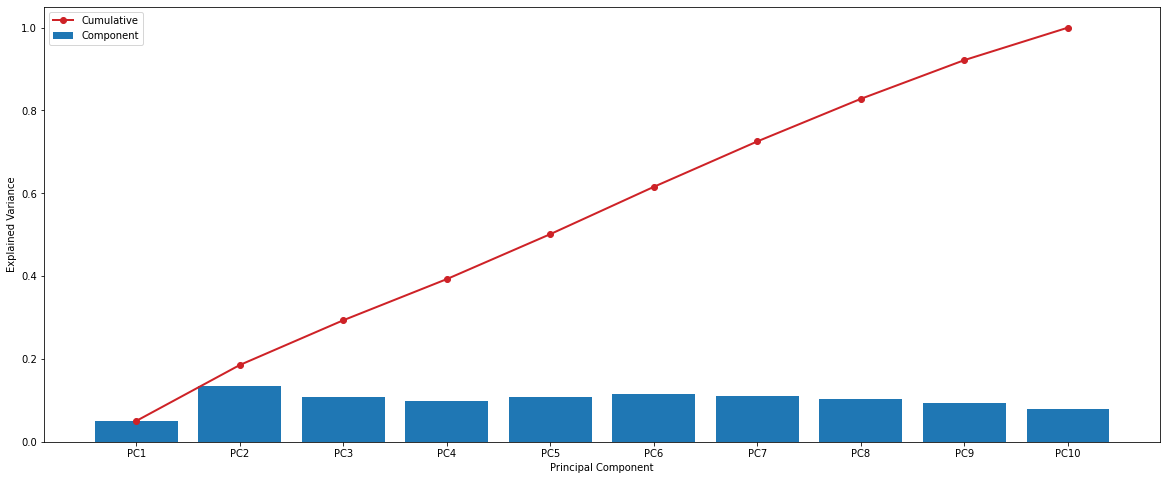

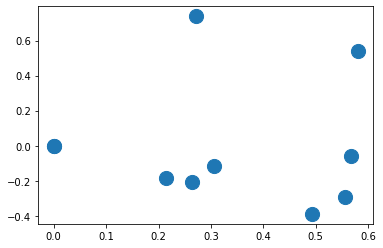

In [13]:
def screeplot(pca, pipeline_component=None, prefix='PC', n_components=None):
    import seaborn as sns
    from matplotlib import pyplot as plt
    
    if pipeline_component is not None:
        pca = pca[pipeline_component]

    explained_variance = pca.explained_variance_ratio_
    if n_components is not None: explained_variance = explained_variance[0:n_components]
    
    total_variance = np.cumsum(explained_variance)
    ticks = range(len(explained_variance))
    labels = [ f'{prefix}{i+1}' for i in ticks ]

    plt.bar(x=range(len(explained_variance)), height=explained_variance, label='Component')
    plt.plot(range(len(total_variance)), total_variance, 'o-', color='#ce2227', linewidth=2, label='Cumulative')
    plt.xticks(ticks=ticks, labels=labels)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance')
    plt.legend()
    
dimred = TruncatedSVD(n_components=len(vocab))
P = dimred.fit_transform(T)
print(f'Requested {len(vocab)} components, got {P.shape[1]}.')

fig = plt.figure(figsize=(20, 8))
screeplot(dimred)
plt.show()

plt.scatter(x=P[:, 0], y=P[:, 1], s=200)
plt.show()

***<span style='color: #ce2227'>TASK 1:</span>*** Note that we requested 64 components from the `TruncatedSVD` object, but only 10 were returned. Why? (Hint: examining the documentation for the [n_components](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#:~:text=Parameters%3A-,n_components,-int%2C%20default%3D2) argument of `PCA` may help here)

Only 10 quotes, only 10 lines meaning there onlt 10 features and n_components must be less or equal t the number of features.

In this particular example, the principal components are somewhat meaningless (which is to be expected, given the tiny sample size). However, in the presence of large amounts of data, they may become quite informative.

### Integrating Vectorizers into Pipelines

Vectorizers serve to extract features from a set of provided inputs, therefore really become useful when they are integrated into pipelines. For example, the plot that was produced earlier by extracting features via tf-idf and then further processed by truncated SVD could be encapsulated via the following pipeline:

In [14]:
f_extract = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dimred', TruncatedSVD())
])

Then, we can extract the two required components directly from our text:

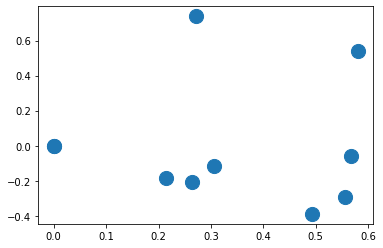

In [15]:
P = f_extract.fit_transform(quotes)
plt.scatter(x=P[:, 0], y=P[:, 1], s=200);

#### Extracting stages from a Pipeline

It is sometimes useful to be able to extract stages from a pipeline after it has been created (e.g., after it has been fit using a `GridSearchCV` object) to inspect or visualise a stage's properties. For example, you may wish to tune the number of principal components extracted by PCA within a supervised learning pipeline, and then use the best-identified PCA configuration to [`inverse_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.inverse_transform) data (see the second assignment).

Extracting the object used at a named stage in a pipeline is simple, we simply identify the name of the stage in question, and use this to index into the pipeline as if a dictionary or list. For example, to extract the `TruncatedSVD` step of our `f_extract` pipeline from the previous step, we would index the `'dimred'` stage of the pipeline:

In [16]:
dimred = f_extract['dimred']
print(f'Extracted a {dimred} object from the pipeline with {dimred.n_components} components.')

Extracted a TruncatedSVD() object from the pipeline with 2 components.


***<span style='color: #ce2227'>TASK 2:</span>*** Recreate the screeplot from earlier in this lab, but this time use a `Pipeline` to encapsulate the work. Make sure that the pipeline contains the required steps (a vectorizer, followed by TF-IDF, and finally truncated SVD that extracts the required number of components). Once the pipeline is constructed and fitted to our test corpus in `quotes`, you will need to extract the TruncatedSVD object from the appropriate step, and then use the supplied `screeplot` function to produce the required plot.

Extracted a TruncatedSVD(n_components=64) object from the pipeline with 64 components.


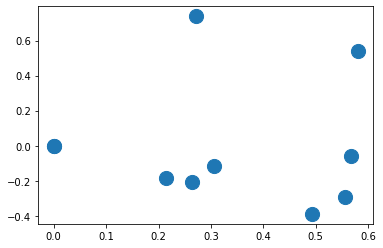

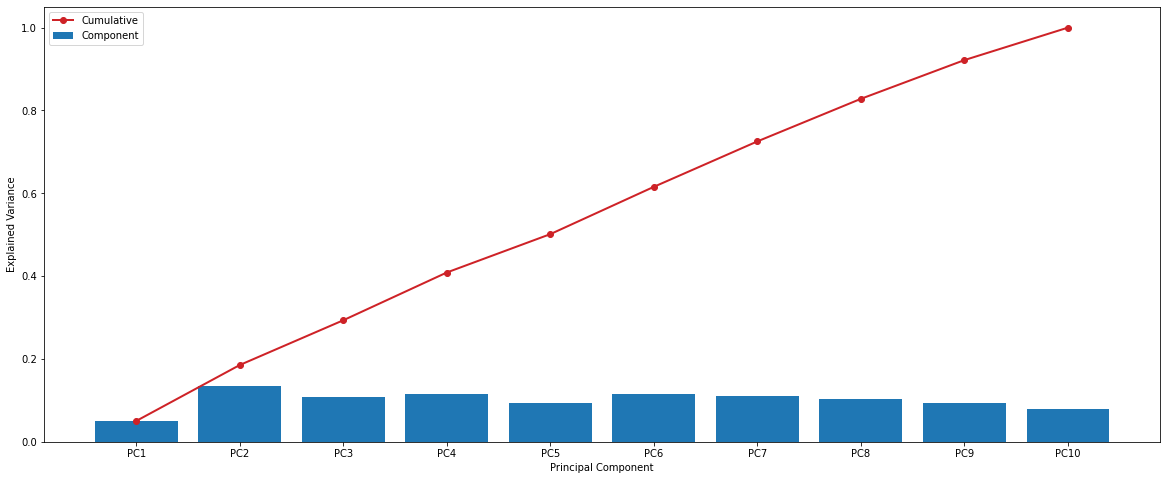

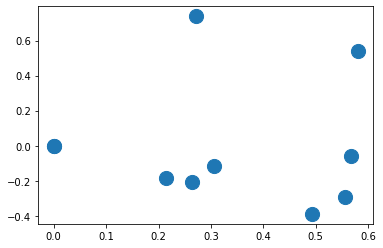

In [17]:
from asyncio.windows_utils import pipe


pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dimred', TruncatedSVD(n_components= len(vocab)))
])
fit = pipe.fit_transform(quotes)
plt.scatter(x=P[:, 0], y=fit[:, 1], s=200);
dimred = pipe['dimred']
print(f'Extracted a {dimred} object from the pipeline with {dimred.n_components} components.')
fig = plt.figure(figsize=(20, 8))
screeplot(dimred)
plt.show()

plt.scatter(x=P[:, 0], y=P[:, 1], s=200)
plt.show()

Naturally, this pipeline could be further extended to include, for example, a supervised learning method like logistic regression. (which is exactly what you will do in the next section!)

## SPAM Detection via NLP

## Data Setup
We have provided a CSV file that contains the contents of emails from a range of sources (we've put this file on dropbox to make it easier for Colab users - if you are working offline, then download the file from [here](https://dl.dropboxusercontent.com/s/nhnfsqyj6a8egx6/spam.csv.gz?dl=0), save it locally, and change the `spam_url` variable to point to this local file). This can be read in using the normal `read_csv` routines:

In [18]:
spam_url = 'https://dl.dropboxusercontent.com/s/nhnfsqyj6a8egx6/spam.csv.gz?dl=0'
spam_df = pd.read_csv(spam_url, index_col=0, compression='gzip')

A quick examination of the data suggests that each email has be presented in a raw text format, and has been labelled as a normal email (class '-') or a spam email (class '+') 

In [19]:
spam_df

,text,class
data/easy_ham\1211.84b0b651923557c12187ec32ed8d5c24,--==_Exmh_2018282504P\n\nContent-Type: text/pl...,-
data/BG\2004\12\1104259025.840_235.txt,<html>\n\nNew ClALlS softtabs = lNSTANT R0CKHA...,+
data/easy_ham\00163.b1c2e35dfbadbea6df3815717933f1fa,"On Tue, 2002-07-30 at 13:17, Patton, Tony wrot...",-
data/GP\part9\msg13444.eml,<html>\n\n<body>\n\n<center>\n\n<body bgcolor=...,+
data/easy_ham\00440.c3f2884506305948c017149cbd75fdcf,Just wondering if anyone has implemented one b...,-
...,...,...
data/GP\part12\msg4179.eml,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",+
data/GP\part3\msg6034.eml,"<META HTTP-EQUIV=3D""Content-Type"" =\n\nCONTENT...",+
data/kaminski-v\rice\17,"Please respond to Hello Vince and Kenneth,\n\n...",-
data/spam\01043.0c5ba977fb678deeff6b841772e76c86,Look this is so hot that not only do you want ...,+


We can then examine specific emails, such as this spam message:

In [20]:
print(spam_df['text'][5])

----0020580349134286

Content-Type: text/plain;

	charset="iso-9661-6"

Content-Transfer-Encoding: quoted-printable

Content-Description: politburo posey nectary



Online pharmacy - Visit our online store and save.



Save up to 80% compared to normal rates.



All popular drugs are available, including Vicodin!



- World wide shipping

- No Doctor Visits

- No Prescriptions

- Next Day Priority Shipping

- Discreet Packaging

- Buy in Bulk and Save!



We make it easier and faster than ever to get the prescriptions you

need.



Go here: http://www.fidrugs.com/rx/?7











No thanks: http://www.fidrugs.com/rmv/









----0020580349134286--



In contrast to this "normal" email:

In [21]:
print(spam_df['text'][0])

--==_Exmh_2018282504P

Content-Type: text/plain; charset=us-ascii



> From:  Chris Garrigues <cwg-bcc@DeepEddy.Com>

> Date:  Mon, 23 Sep 2002 09:41:22 -0500

>

> > From:  Scott Lipcon <slipcon@mercea.net>

> > Date:  Sun, 22 Sep 2002 22:58:16 -0400

> >

> > I just updated to the latest CVS - I had been running a build from June. 

>  

> > Hitting the Flist button gives the following traceback:

> > 

> > syntax error in expression "int(17+1+(222-)*(19-17-2)/(224-))"

> >     while executing

> > "expr int($minLine+1+($msgid-$minMsg)*($maxLine-$minLine-2)/($maxMsg-$minMs

> > g))"

> >     (procedure "Ftoc_FindMsg" line 57)

> >     invoked from within

> > "Ftoc_FindMsg $i"

> >     (procedure "Ftoc_ShowSequences" line 16)

> >     invoked from within

> > "Ftoc_ShowSequences $F"

> >     (procedure "ScanFolder" line 81)

> >     invoked from within

> > "ScanFolder inbox 0"

> >     invoked from within

> > "time [list ScanFolder $F $adjustDisplay"

> >     (procedure "Scan_Folde

For this lab, we will set up a training and testing split, with 10000 instances reserved for testing.

In [22]:
text = spam_df['text'].astype('U')
lab  = spam_df['class'].to_numpy()
text_train, text_test, lab_train, lab_test = train_test_split(text, lab, train_size=10000, stratify=lab, random_state=1234)

res = [ 0, 2, 4, 5 ]
display(spam_df.iloc[res])

,text,class
data/easy_ham\1211.84b0b651923557c12187ec32ed8d5c24,--==_Exmh_2018282504P\n\nContent-Type: text/pl...,-
data/easy_ham\00163.b1c2e35dfbadbea6df3815717933f1fa,"On Tue, 2002-07-30 at 13:17, Patton, Tony wrot...",-
data/easy_ham\00440.c3f2884506305948c017149cbd75fdcf,Just wondering if anyone has implemented one b...,-
data/BG\2005\01\1106777559.21561_70.txt,----0020580349134286\n\nContent-Type: text/pla...,+


From the remaining instances used for training, we will use cross validation to select an appropriate model and evaluate this model on our test data.

### Principal Component Analysis

***<span style='color: #ce2227'>TASK 3:</span>*** Perform a Truncated SVD analysis of the training text corpus of SPAM emails. Use a maximum of 32 components and provide a screeplot of the result. Use a `Pipeline` for this.

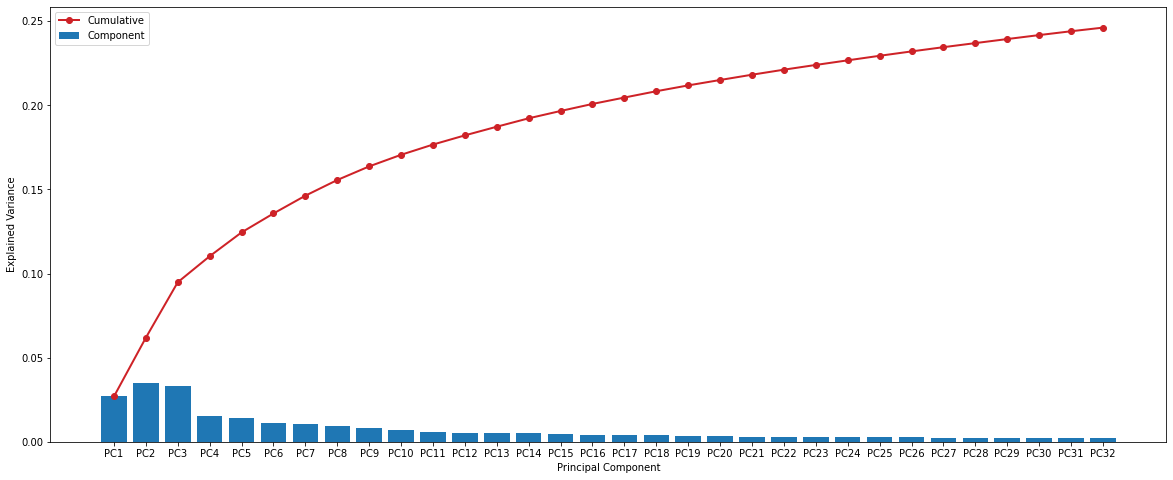

In [23]:
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dimred', TruncatedSVD(n_components= 32))
])
fit = pipe.fit_transform(text_train)

dimred = pipe['dimred']
fig = plt.figure(figsize=(20, 8))
screeplot(dimred)
plt.show()


### Obtaining a baseline

Before continuing with the actual modelling, it would be useful to obtain a measure of baseline performance, so we know what a "good" model should be providing in terms of accuracy or F<sub>1</sub> score. Recall that you can do this via a dummy classifier.

***<span style='color: #ce2227'>TASK 4:</span>*** Construct a dummy classifier on our training data, and measure its performance on our test data. Use a [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) call to describe its performance and print a `confusion_matrix`.

In [24]:
dummy = DummyClassifier().fit(text_train, lab_train)
pred = dummy.predict(text_test)
cr = classification_report(lab_test, pred, zero_division= 0 )
cm= confusion_matrix(lab_test, pred)
print(cm)
print(cr)

[[24622     0]
 [18314     0]]
              precision    recall  f1-score   support

           +       0.57      1.00      0.73     24622
           -       0.00      0.00      0.00     18314

    accuracy                           0.57     42936
   macro avg       0.29      0.50      0.36     42936
weighted avg       0.33      0.57      0.42     42936



### Wrapping it all up

At this point, you have actually seen everything that you need to build a classifier for spam detection - you have seen how vectorizers work, how to build a pipeline and how to select a model via cross validation. So, let's get to it!

First, we are going to use cross validation - this is a large data set, so to keep things relatively manageable, we will perform a single pass of 5-fold ross validation. We'll also use an $F_1$ scorer (even though there's only slight class imbalance). Next, we need set up a suitable pipeline to allow us to explore using either a `CountVectorizer` or a `TfidfVectorizer`, along with the required tuning grid. Finally, we will run the cross validation search on the pipeline, and extract the results. You've seen this process enough times now, so let's just rip through the code in one go!

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)
split_test_score_columns = [ f'split{i}_test_score' for i in range(kf.n_splits) ]

scorer = make_scorer(f1_score, average='macro')

lm = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', None),
    ('lm', LogisticRegression(max_iter=10000))
])

param_grid = {
    'tfidf' : [ 'passthrough', TfidfTransformer() ],
}

cv = GridSearchCV(lm, param_grid=param_grid, scoring=scorer, cv=kf, n_jobs=-1).fit(text_train, lab_train)

0.984085766791359 {'tfidf': 'passthrough'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,29.589906,1.060974,0.559604,0.122074,passthrough,{'tfidf': 'passthrough'},0.984750,0.981245,0.985686,0.984678,0.984069,0.984086,0.001511,1
1,10.879459,0.992000,1.252815,0.158434,TfidfTransformer(),{'tfidf': TfidfTransformer()},0.983227,0.979237,0.981613,0.976553,0.977917,0.979710,0.002425,2


<AxesSubplot:>

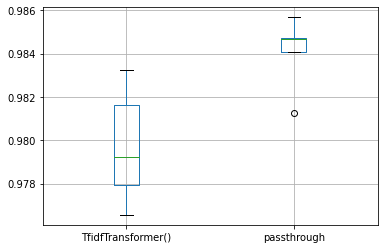

In [26]:
print(cv.best_score_, cv.best_params_)

cv_results = pd.DataFrame(cv.cv_results_)
display(cv_results)

cv_results.melt(id_vars=['param_tfidf'], value_vars=[ f'split{i}_test_score' for i in range(kf.n_splits) ]).pivot(index='variable', columns='param_tfidf', values='value').boxplot()

***<span style='color: #ce2227'>TASK 5:</span>*** Evaluate the best CV model on the test data, using the same process as used for the dummy classifier.

In [27]:

pred = cv.best_estimator_.predict(text_test)
cr = classification_report(lab_test, pred, zero_division= 0 )
cm= confusion_matrix(lab_test, pred)
print(cm)
print(cr)

[[24235   387]
 [  232 18082]]
              precision    recall  f1-score   support

           +       0.99      0.98      0.99     24622
           -       0.98      0.99      0.98     18314

    accuracy                           0.99     42936
   macro avg       0.98      0.99      0.99     42936
weighted avg       0.99      0.99      0.99     42936



***<span style='color: #ce2227'>TASK 6:</span>*** Extend the pipeline defined in the previous example so that it includes a `TruncatedSVD` step within the process. Extend the cross validation tuning grid so that it explores the following number of components for the truncated SVD: [ 1, 2, 4, 8, 16, 32, 64 ]. Tune the pipeline using a `GridSearchCV` object, and convert the `cv_results_` attribute of this object (after fitting) to a data frame.

In [28]:
SVD=[1,2,4,8,16,32,64]

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
split_test_score_columns = [ f'split{i}_test_score' for i in range(kf.n_splits) ]

scorer = make_scorer(f1_score, average='macro')

lm = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', None),
    ('dimred', None),
    ('lm', LogisticRegression(max_iter=10000))
])
param_grid = {
    'tfidf' : [ 'passthrough', TfidfTransformer()],
     'dimred': [TruncatedSVD()],
     'dimred__n_components': SVD

}
cv = GridSearchCV(lm, param_grid=param_grid, scoring=scorer, cv=kf, n_jobs=-1).fit(text_train, lab_train)
print(cv.best_score_, cv.best_params_)

cv_results = pd.DataFrame(cv.cv_results_)
display(cv_results)


0.9644931324375385 {'dimred': TruncatedSVD(n_components=64), 'dimred__n_components': 64, 'tfidf': TfidfTransformer()}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dimred,param_dimred__n_components,param_tfidf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.329640,0.290959,1.277363,0.295940,TruncatedSVD(n_components=64),1,passthrough,"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.362245,0.360409,0.365079,0.365683,0.368886,0.364461,0.002925,14
1,8.970509,0.659978,1.506797,0.207159,TruncatedSVD(n_components=64),1,TfidfTransformer(),"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.864419,0.841830,0.858317,0.844216,0.850101,0.851777,0.008503,12
2,9.038310,0.404895,1.360537,0.129198,TruncatedSVD(n_components=64),2,passthrough,"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.361838,0.360409,0.698952,0.734020,0.378738,0.506791,0.171695,13
3,8.791033,1.352523,1.443441,0.225933,TruncatedSVD(n_components=64),2,TfidfTransformer(),"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.894787,0.896362,0.888180,0.890149,0.892442,0.892384,0.002976,9
4,10.423541,0.517440,1.331535,0.134619,TruncatedSVD(n_components=64),4,passthrough,"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.876910,0.869981,0.853979,0.872776,0.875115,0.869752,0.008222,10
5,10.184959,0.409073,1.284683,0.141679,TruncatedSVD(n_components=64),4,TfidfTransformer(),"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.896772,0.896346,0.892118,0.893122,0.893895,0.894451,0.001816,8
6,10.494932,2.103487,1.473498,0.371791,TruncatedSVD(n_components=64),8,passthrough,"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.858964,0.867485,0.863443,0.844970,0.867175,0.860407,0.008313,11
7,13.095761,1.546133,1.702978,0.274645,TruncatedSVD(n_components=64),8,TfidfTransformer(),"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.901724,0.905277,0.895572,0.897567,0.901782,0.900385,0.003429,6
8,16.336595,1.412869,1.485723,0.080847,TruncatedSVD(n_components=64),16,passthrough,"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.908030,0.892257,0.904836,0.891542,0.891867,0.897706,0.007200,7
9,16.290071,1.978860,1.666896,0.464518,TruncatedSVD(n_components=64),16,TfidfTransformer(),"{'dimred': TruncatedSVD(n_components=64), 'dim...",0.916492,0.918624,0.922735,0.922328,0.919622,0.919960,0.002334,5


***<span style='color: #ce2227'>TASK 7:</span>*** Evaluate the best CV model on the test data, using the same process as used for the two previous examples. Also, produce a line plot of the cross validation tuning results, with the x axis being the number of components, the y axis being the cross validation test score, and "hue" being whether TF-IDF was used or not:

<AxesSubplot:xlabel='param_dimred__n_components', ylabel='value'>

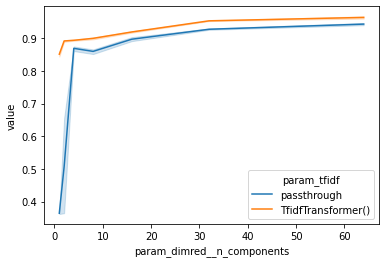

In [29]:
cv2 = cv_results.melt(id_vars=['param_tfidf', 'param_dimred__n_components'], value_vars=[ f'split{i}_test_score' for i in range(kf.n_splits) ])
sns.lineplot(data = cv2, x = 'param_dimred__n_components', y = 'value', hue = 'param_tfidf')
## suppresses relevance of common words

***<span style='color: #ce2227'>TASK 8:</span>*** If you have done everything correctly in the previous step, you should notice that using TF-IDF results in requiring far fewer components from the `TruncatedSVD` object in the pipeline in order to achieve good performance. Why do you think this is?

tfidf suprreses relevance of common words which achieves better performance and the number of components will be lower.

***<span style='color: #ce2227'>TASK 9:</span>*** Extract the `TruncatedSVD` object of the pipeline identified through cross validation (i.e., the `GridSearchCV` object's `best_estimator_` attribute will be a pipeline - identify the step within the pipeline that contains the `TuncatedSVD` object, and extract the object from this step). Perform a screeplot on this `TruncatedSVD` object:

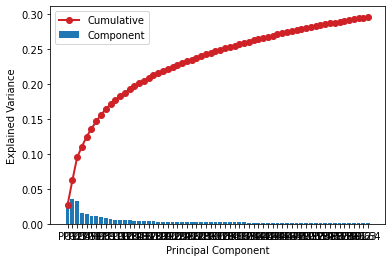

In [30]:
screeplot(cv.best_estimator_["dimred"])

### Computing finer-grained prediction outcomes (TRUE/FALSE -/+)

The prediction performance used above is macroscopic in assessment - a prediction is either right or wrong. We can get further insights by knowing the nature of the error (e.g., a negative instance predicted as positive is a different type of error than a positive instance predicted as negative).

Recall that, for binary classification, we have four outcomes:
  1. True Positive - the prediction was positive, and this prediction is correct (i.e., the instance was also positive)
  2. True Negative - the prediction was negative, and this prediction is correct (i.e., the instance was also negative)
  3. False Positive - the prediction was positive, and this prediction is wrong (i.e., the instance was negative)
  4. False Negative - the prediction was negative, and this prediction is wrong (i.e., the instance was positive)
  
We can extract this from our `lab_test` and `lab_pred` variables as follows:

In [31]:
def label_outcomes(t, y, positive_target=None, labels=np.array([ 'FN', 'FP', 'TN', 'TP' ])):
    if positive_target is None: positive_target=t[0]
    if not isinstance(labels, np.ndarray): labels = np.array(labels)
    if not isinstance(t, np.ndarray): t = np.array(t)
    if not isinstance(y, np.ndarray): y = np.array(y)

    true_outcome = t == y
    positive_outcome = y == positive_target
    
    return labels[2 * true_outcome + positive_outcome ]

outcome = label_outcomes(lab_test, pred, '+', labels=np.array([ 'False -', 'False +', 'True -', 'True +' ]))
outcome

array(['True -', 'True -', 'True -', ..., 'True -', 'True +', 'True +'],
      dtype='<U7')

You can then use this information to interrogate examples to hopefully better understand why they were (mis)classified in such a way. For example, let's look at a false positive example:

In [32]:
print(text_test[outcome=='False +'][1])

Dear Louise,



Thank you for using Register.com to submit

citigroupenergy.com for registration.



A host of helpful Register.com tools and services come with

citigroupenergy.com.



Take advantage of the following at no additional charge:



-A 3 page Web site with our FirstStepSite(TM) tool!

http://www.firststepsite.com/



-A personalized email account

http://www.register.com/email-services/



-URL forwarding through FirstStepPortal(TM)

http://www.register.com/url-jump.cgi



-Superior Customer Support, 24 hours a day, 7 days a week.

Submit inquiries to:

http://www.register.com/create_ticket.cgi



In addition, Register.com is pleased to offer many valuable

services to help extend your online presence:



----Promote your site----

Submit your Web site to over 500 search engines automatically

with our easy Site Submit service.  Do it today at

http://www.register.com/site-jump.cgi



----Distinguish your brand ---

The new specialized domain name extensions allow you to



Likewise, we can examine false negatives (spam email that were classified as normal):

In [33]:
print(text_test[outcome=='False -'][0])

Hello objective-view.de



I wanted follow up to yesterdays email to point out the Glasglow Partner

Program to those who may be interested. We offer a 40% discount and

exclusive license agreement for your region. We do dropship using DHL free

of charge. If this may be something that interests you please let me know.



If we are already in negotiation, exchanged links or you have listed

yourself on the remove list please disregard this email and no further

reply is required.



Sincerely

Michael



www.glasglow.com









If you do not wish to receive further updates please enter your email at

http://www.cbxsales.com/un.html. They have agreed to send us the remove

lists so that we do not keep bothering those that do not wish to be

bothered. 





## Wrap-Up

In this lab, you have seen how bag of words feature contruction (and the related tf-idf) can be used to extract features from variable-length text documents and use them in supervised learning.